In [46]:
import pandas as pd
import numpy as np
from competition.data_gen_costs import *
from competition.test_case import TestCase
from competition.data_collection_ctrls import Controller, yaw_rot, INITIAL_GATE_EXIT
import tqdm

In [47]:

df = pd.read_csv('data.csv')

In [48]:
subset = df[df["v0"] < 1.5]
subset.loc[subset['best_v'] > 1.5, 'best_v'] = 4/3

/var/folders/q3/0mld71gj36v0xnwbht7h83l00000gn/T/ipykernel_26119/2966962893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[subset['best_v'] > 1.5, 'best_v'] = 4/3


In [49]:
failed = []
for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
  g2 = np.arctan2(np.sin(row["theta1"] + row["theta2"]), np.cos(row["theta1"] + row["theta2"]))
  
  # add gates to the map convert local frame data in test_case to global frame
  second_gate_pos = np.array([0, 0, row["z0"]]) + row["d1"] * (yaw_rot(0) @ INITIAL_GATE_EXIT)
  second_gate_pos[2] = row["z1"]
  third_gate_pos = second_gate_pos + row["d2"] * (yaw_rot(row["theta1"]) @ INITIAL_GATE_EXIT)
  third_gate_pos[2] = row["z2"]
  
  initial_info = {
    "ctrl_timestep": 30,
    "ctrl_freq": 30,
    "nominal_gates_pos_and_type": [
      [0, 0, 0, 0, 0, 0, 1 if row["z0"] == 0.3 else 0],
      [second_gate_pos[0], second_gate_pos[1], 0, 0, 0, row["theta1"], 1 if row["z1"] == 0.3 else 0],
      [third_gate_pos[0], third_gate_pos[1], 0, 0, 0, g2, 1 if row["z2"] == 0.3 else 0]
    ],
    "nominal_obstacles_pos": [],
    "quadrotor_kf": 0
  }

  ctrl = Controller(None, initial_info)
  tc = TestCase(row["z0"], row["v0"], row["d1"], row["theta1"], row["z1"], row["d2"], row["theta2"], row["z2"])
  ctrl.build_traj(tc, row["best_v"], row["best_t"])
  if np.max(ctrl.ref_acc) > 5:
    failed.append(i)

  7%|▋         | 9039/129600 [00:05<01:16, 1582.13it/s]


KeyboardInterrupt: 

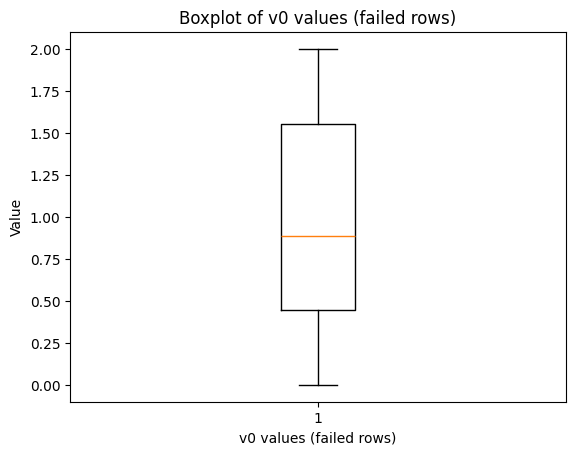

In [ ]:
import matplotlib.pyplot as plt

# Select the "v0" values for the failed rows
v0_failed = df.iloc[failed]["v0"]

# Create a boxplot
plt.boxplot(v0_failed)

# Add labels and title
plt.xlabel("v0 values (failed rows)")
plt.ylabel("Value")
plt.title("Boxplot of v0 values (failed rows)")

# Display the plot
plt.show()

In [ ]:
row = df.iloc[failed[0]]
print(row)
row["best_t"] = 2.0
g2 = np.arctan2(np.sin(row["theta1"] + row["theta2"]), np.cos(row["theta1"] + row["theta2"]))
  
# add gates to the map convert local frame data in test_case to global frame
second_gate_pos = np.array([0, 0, row["z0"]]) + row["d1"] * (yaw_rot(0) @ INITIAL_GATE_EXIT)
second_gate_pos[2] = row["z1"]
third_gate_pos = second_gate_pos + row["d2"] * (yaw_rot(row["theta1"]) @ INITIAL_GATE_EXIT)
third_gate_pos[2] = row["z2"]

initial_info = {
  "ctrl_timestep": 30,
  "ctrl_freq": 30,
  "nominal_gates_pos_and_type": [
    [0, 0, 0, 0, 0, 0, 1 if row["z0"] == 0.3 else 0],
    [second_gate_pos[0], second_gate_pos[1], 0, 0, 0, row["theta1"], 1 if row["z1"] == 0.3 else 0],
    [third_gate_pos[0], third_gate_pos[1], 0, 0, 0, g2, 1 if row["z2"] == 0.3 else 0]
  ],
  "nominal_obstacles_pos": [],
  "quadrotor_kf": 0
}

ctrl = Controller(None, initial_info)
tc = TestCase(row["z0"], row["v0"], row["d1"], row["theta1"], row["z1"], row["d2"], row["theta2"], row["z2"])
ctrl.build_traj(tc, row["best_v"], row["best_t"])

print(np.max(ctrl.ref_acc))

v0        1.555556
z0        0.300000
d1        0.800000
theta1   -0.785398
z1        0.300000
d2        0.800000
theta2   -0.785398
z2        0.300000
best_v    1.333333
best_t    3.000000
Name: 90720, dtype: float64
2.8288330879823236


In [ ]:
print(len(failed))

0


In [50]:
print(df["best_v"].max())
print(df["best_t"].max())

row = df.iloc[df["best_v"].idxmax()]
print(row)

1.5555555555555554
2.25
v0        0.000000
z0        0.300000
d1        1.500000
theta1   -0.112200
z1        0.300000
d2        1.360000
theta2   -0.785398
z2        0.300000
best_v    1.555556
best_t    1.735714
Name: 5856, dtype: float64
